# Inactives

For testing purposes.

In [26]:
import cPickle as pickle

from local_utils.rdkit_utils import FP

## Config

In [27]:
# Maximun number of inactives to take if available...

n_max = 1000

In [28]:
# ChEMBL connection...

engine = create_engine(open('database.txt').read().strip())

##  Actives

Active parent compounds for those Human targets which have at least the minimium required number of actives (_i.e._ those involved in the model building).

* See notebook '[10_Get_actives_and_mols](10_Get_actives_and_mols.ipynb)' for further details of files'`actives.pkl` and '`active_mols.pkl`'.

In [29]:
actives, active_mols = pickle.load(open('actives.pkl'))

actives.shape, active_mols.shape

((167055, 2), (104749, 3))

In [30]:
actives.head(1)

,symbol,usmiles
symbol,,
ABCB1,ABCB1,C=CC(C)(C)c1c(O)cc(O)c2c(=O)c(O)c(-c3ccc(OC)cc3)oc12


,mol,FP,core_smiles
usmiles,,,
C=CC(C)(C)c1c(O)cc(O)c2c(=O)c(O)c(-c3ccc(OC)cc3)oc12,,"[0 0 0 ..., 0 0 0]",O=c1cc(-c2ccccc2)oc2ccccc12

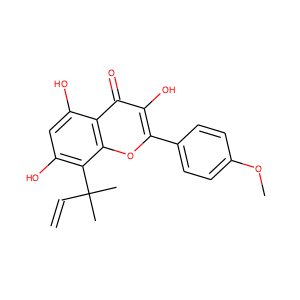

In [31]:
active_mols.head(1)

## Get Inactives

Get all inactives for the targets of interest.

Attempt to select those that are relatively unambiguous.

In [32]:
# Symbols for the targets of interest...

symbols = actives.index.unique().tolist()

len(symbols)

138

In [33]:
inactives = pd.read_sql("""
    select
          a.symbol
        , a.usmiles
    from 
        tt_activity_counts a
        join (select distinct usmiles, nat from tt_structure_lookup) b on a.usmiles = b.usmiles
    where
        a.species = 'Human'
    and a.n_active = 0
    and b.nat >= 10
    and b.nat <= 50
    and symbol in ({})
""".format(','.join("'{}'".format(x) for x in symbols)), engine)

inactives.shape

(192530, 2)

In [34]:
# Count of inactives meeting conditions...

counts = actives.groupby('symbol').apply(len).to_frame('n_active').merge(inactives.groupby('symbol').apply(len).to_frame('n_inactive'), left_index=True, right_index=True)

counts.shape

(138, 2)

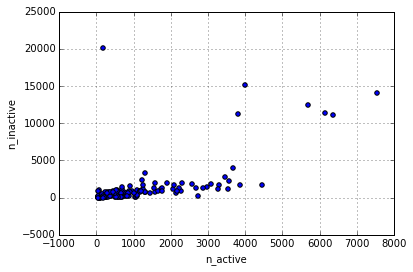

In [37]:
counts.plot(x='n_active', y='n_inactive', kind='scatter')

In [39]:
counts.sort('n_inactive', ascending=False).head()

,n_active,n_inactive
symbol,,
VDR,175,20064
CYP2D6,4010,15119
CYP3A4,7545,14023
CYP2C9,5685,12399
CYP1A2,6140,11399


## Subset Inactives

Due to the large imbalance of numbers, make a (random) selection for the more abundant targets.

In [15]:
inactives0 = inactives

In [16]:
def f(group):
    
    compounds = group['usmiles'].values

    n_mols = compounds.size
        
    subset = compounds[np.random.permutation(n_mols)[:min(n_mols, n_max)]]
    
    return pd.DataFrame({'usmiles': subset})

inactives = inactives.groupby('symbol').apply(f)\
    .reset_index(level=1, drop=True)\
    .reset_index().sort(['symbol', 'usmiles'])\
    .reset_index(drop=True)

inactives.shape

(81966, 2)

In [17]:
# Sanity check: no overlap between (symbol, compound) pairs for actives and inactives...

a = set(x for x in actives[['symbol', 'usmiles']].itertuples(index=False))

b = set(x for x in inactives.itertuples(index=False))

assert len(a.intersection(b)) == 0

In [18]:
# Counts...

inactives.groupby('symbol').apply(len).to_frame('count').sort('count', ascending=False)

,count
symbol,
VDR,1000
CYP1A2,1000
ESR1,1000
AURKA,1000
ERBB2,1000
PTGS2,1000
EGFR,1000
OPRM1,1000
DRD2,1000


### Reformat

Reformat to molecule-centric view.

In [19]:
inactive_mols = inactives.groupby('usmiles')\
    .apply(lambda x: pd.Series({'symbols': x['symbol'].tolist()}))\
    .reset_index()

PandasTools.AddMoleculeColumnToFrame(inactive_mols, smilesCol='usmiles', molCol='mol')

inactive_mols['FP'] = inactive_mols['mol'].apply(FP)

inactives.shape, inactive_mols.shape

((81966, 2), (35377, 4))

In [20]:
inactives.head(1)

,symbol,usmiles
0,ABCB1,Brc1cccc(Nc2nc(-c3ccccc3)nc3ccccc23)c1


,usmiles,symbols,mol,FP
0,Brc1c(Br)c(Br)c2[nH]cnc2c1Br,[DRD1],,"[0 0 0 ..., 0 0 0]"

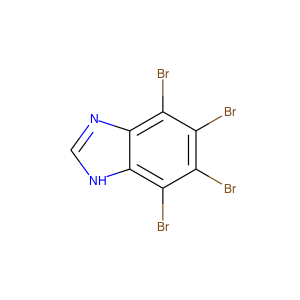

In [21]:
inactive_mols.head(1)

### Export

In [22]:
pickle.dump([inactives, inactive_mols], open('inactives.pkl', 'w'))

# inactives, inactive_mols = pickle.load(open('inactives.pkl'))